In [ ]:
# default_exp gbe.baseline_drinking.separate

# Factor analysis
Factor analyses require large sample sizes, which this study is perfect for.

> Note: Next step is to get the scoring data per session so tasks is a session-based df. Then this df is averaged before the factor analysis, but session-level scores are used to generate factor scores.

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)
from IPython.core.display import HTML

In [ ]:
#export
%load_ext autoreload
%autoreload 2
from trr265.gbe.ist.data_provider import ISTDataProvider
from trr265.gbe.wm.data_provider import WMDataProvider
from trr265.gbe.sst.data_provider import SSTDataProvider
from trr265.gbe.rtt.data_provider import RTTDataProvider

import trr265.gbe.ist.scoring as ist_scoring 
import trr265.gbe.wm.scoring as wm_scoring 
import trr265.gbe.sst.scoring as sst_scoring 
import trr265.gbe.rtt.scoring as rtt_scoring 

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

### Information sampling task

In [ ]:
# Getting raw data
dp = ISTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_ist_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")
ist = ist_scoring.get_oversampling_predicted_joint(df)[0]
ist = ist.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#ist = ist.groupby('participant').mean()
ist.columns = ['ist_oversampling','participant','session_number']

R[write to console]: Lade nötiges Paket: lme4

R[write to console]: Lade nötiges Paket: Matrix

R[write to console]: 
Attache Paket: ‘lmerTest’


R[write to console]: Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer


R[write to console]: Das folgende Objekt ist maskiert ‘package:stats’:

    step




### Working memory task

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")

# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)
wm = wm_scoring.get_perc_correct_predicted_sep_trial(df)[0]
wm = wm.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#wm = wm.groupby('participant').mean()
wm = wm.rename(columns={'perc_predicted_sep_trial_no_distractor_1': 'wm_no_1',
                       'perc_predicted_sep_trial_no_distractor_2': 'wm_no_2',
                       'perc_predicted_sep_trial_encoding_distractor': 'wm_encoding',
                       'perc_predicted_sep_trial_delayed_distractor':'wm_delayed'})

8 participants used an old version of the task in some of their sessions.  13 sessions (1.45%) were removed from the dataset.
11 sessions (1.25%) were removed because participants failed a level two trial.


### Risk taking task

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")

rtt = rtt_scoring.get_perc_gamble_predicted_joint(df)[0]
rtt = rtt.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#rtt = rtt.groupby('participant').mean()
rtt = rtt.rename(columns={'perc_gamble_joint_win': 'rtt_win',
                       'perc_gamble_joint_loss': 'rtt_loss',
                       'perc_gamble_joint_mixed': 'rtt_mixed'})

### Stop signal task

In [ ]:
# Getting raw data
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_sst_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
#df = df.query("is_initial and is_baseline")
df = df.query("is_baseline == True")

sst = sst_scoring.get_ssrt_predicted_joint(df)[0]
sst = sst.merge(dp.get_gbe_data(columns = ['participant','session_number']), left_on = 'gbe_index', right_index = True, how = 'left')
#sst = sst.groupby('participant').mean()
sst.columns = ['ssrt','participant','session_number']
sst['ssrt'] = -sst.ssrt # We reverse the SSRTs to align them with other cognitive control measures

## Factor analysis
Using oblimin rotation similar to Eisenberg.

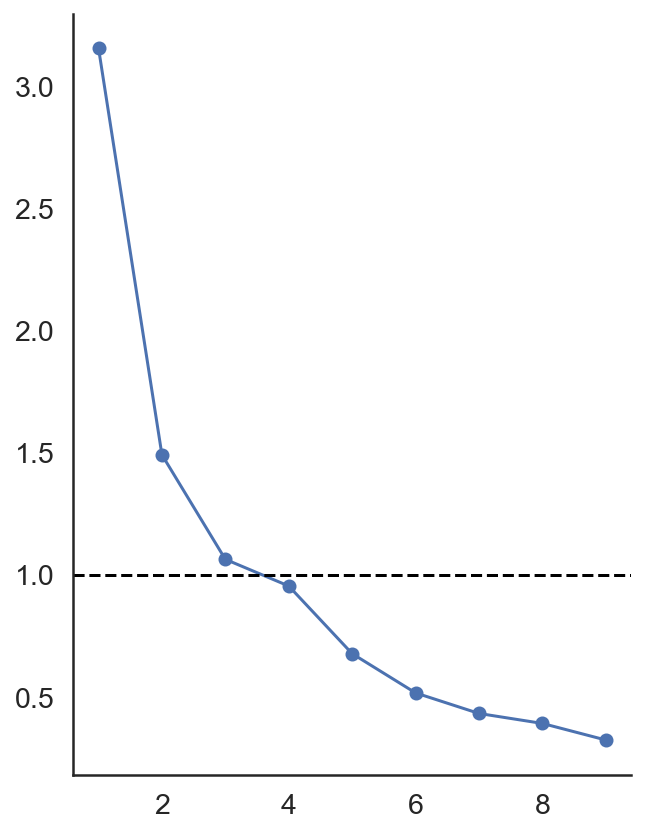

0.8292199984703638


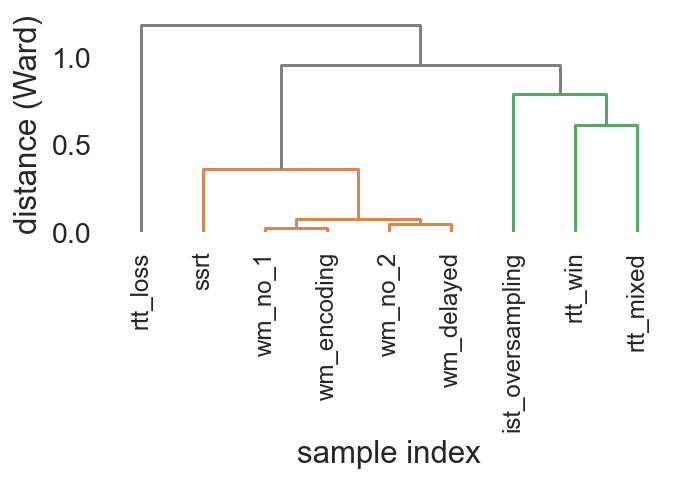

<AxesSubplot:>

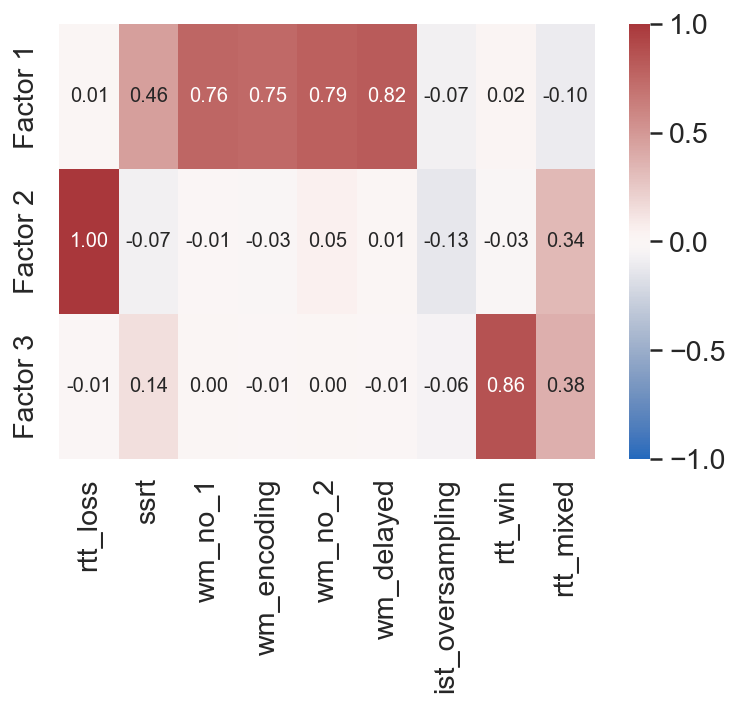

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo # The factor_analyzer package is based on the R psych package
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer

from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

def check_factor_analysis(df):
    # Testing suitability for factor analysis
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    kmo_all,kmo_model=calculate_kmo(df)
    bartletts_passed = "passes" if p_value < .05 else "failed"
    display(HTML("Bartlett's test %s: chi_square = %.2f; p = %.2e; Kaiser-Meyer-Olkin test: %.3f (ideally should be above .8)."%(bartletts_passed, chi_square_value, p_value,kmo_model)))
    
    
def scree_plot(df, rotation = 'oblimin'):
    fa = FactorAnalyzer(rotation=rotation)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    fig, axes = plt.subplots(1, 1, figsize=(5, 7))
    plt.scatter(range(1, df.shape[1]+1),ev)
    ax = plt.plot(range(1, df.shape[1]+1),ev)
    plt.axhline(1, color = 'black', linestyle = '--')
    plt.show()
    
def factor_analysis(df, n_factors, rotation = 'oblimin'):
    fa = FactorAnalyzer(rotation=rotation, n_factors = n_factors)
    fa.fit(df)
    return fa

def get_factor_loadings(fa, df):
     return pd.DataFrame(fa.loadings_, columns = ["Factor %d"%i for i in range(1, fa.n_factors+1)], index = df.columns)
    
def dendogram(df, distances = 'euclidean'):
    #d = np.transpose(np.arange(1,10001).reshape(100,100))
    d = df.values
    distances = pdist(d, distances) #euclidean
    link = linkage(distances, "average")
    default_color_threshold = 0.7*np.max(link[:,2])
    print(default_color_threshold)
    fig, axes = plt.subplots(1, 1, figsize=(5, 2))
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    plt.xlabel('sample index')
    plt.ylabel('distance (Ward)')
    dendo = dendrogram(link, labels=df.index, leaf_rotation=90,color_threshold=default_color_threshold, above_threshold_color= 'grey')
    plt.show()
    return dendo
    
def factor_loading_heatmap(factor_loadings,column_order):
    return sns.heatmap(factor_loadings.T[column_order], annot=True, center = 0, vmin=-1, vmax=1, cmap = sns.color_palette("vlag", as_cmap=True), fmt=".2f", annot_kws={'size': 10})


# Calculating factors based on average session scores   
tasks = pd.concat([wm.groupby('participant').mean(), 
                   sst.groupby('participant').mean(), # Note that we reversed the SST data
                   rtt.groupby('participant').mean(),
                   ist.groupby('participant').mean()],axis = 1).dropna().drop(columns='session_number')

check_factor_analysis(tasks)
scree_plot(tasks, rotation = 'oblimin')
fa = factor_analysis(tasks, 3, rotation = 'oblimin')
factor_loadings = get_factor_loadings(fa, tasks)
dendo = dendogram(factor_loadings)
factor_loading_heatmap(factor_loadings, dendo['ivl'])


In [ ]:
import pickle
with open('../data/interim/fa.pkl', 'wb') as f:
    pickle.dump(fa,f)

#### A four factor solution

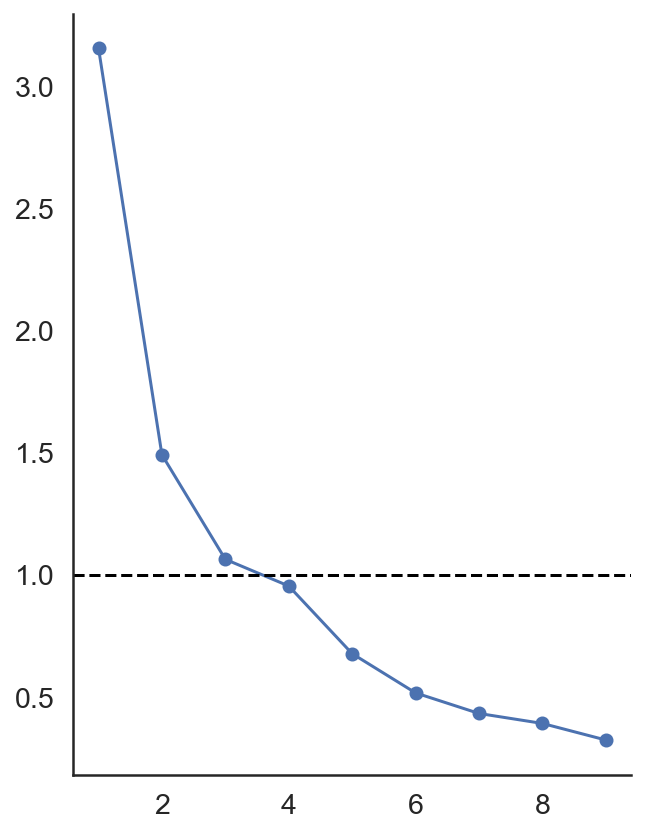

0.8012758423734498


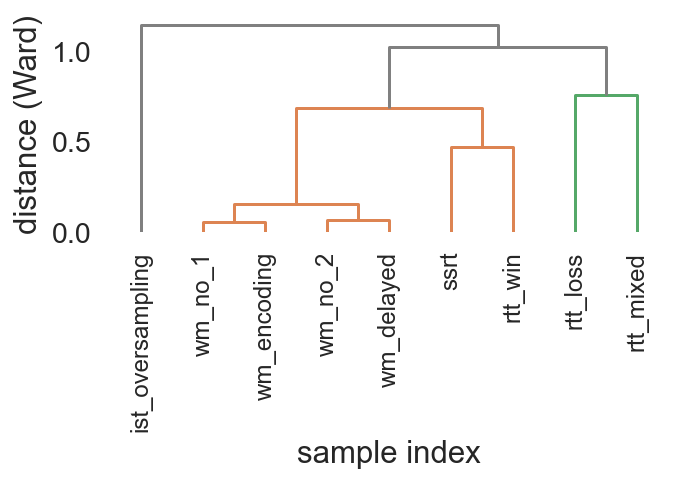

<AxesSubplot:>

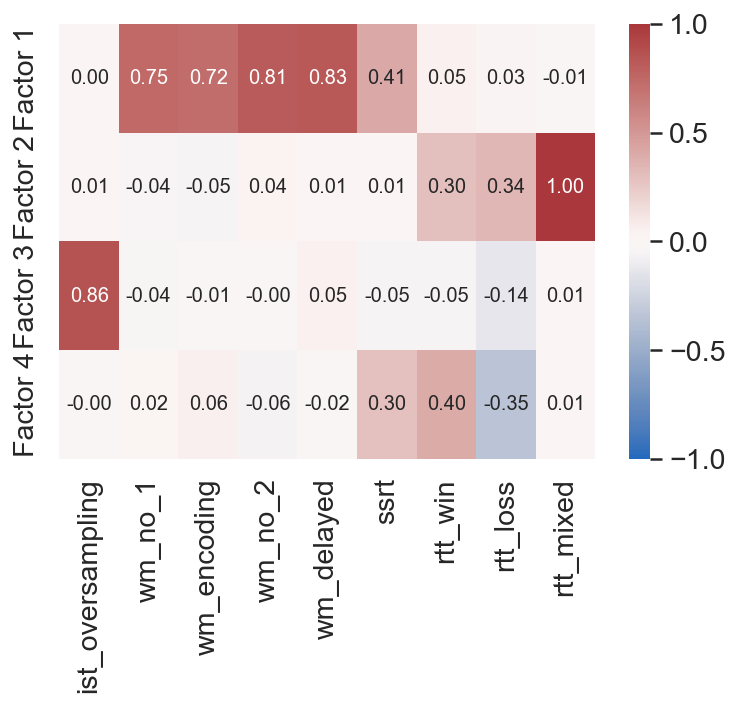

In [ ]:
check_factor_analysis(tasks)
scree_plot(tasks, rotation = 'oblimin')
fa4 = factor_analysis(tasks, 4, rotation = 'oblimin')
factor_loadings4 = get_factor_loadings(fa4, tasks)
factor_loadings4
dendo = dendogram(factor_loadings4)
factor_loading_heatmap(factor_loadings4, dendo['ivl'])

### Factor scores
Factor scores calculated via the ten Berge method (for oblim rotation; Eisenberg; https://www.sciencedirect.com/science/article/pii/S0024379597100076; https://stackoverflow.com/questions/67856186/correct-way-to-calculate-correlations-between-factors).

In [ ]:
import warnings
import numpy as np
from sklearn.preprocessing import scale

def matrix_sqrt(x):
    """
    Compute the square root of the eigen values (eVal),
    and then take $eVec * diag(eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    evals[evals < 0] = np.finfo(float).eps
    sqrt_evals = np.sqrt(evals)
    return evecs.dot(np.diag(sqrt_evals)).dot(evecs.T)


def inv_matrix_sqrt(x):
    """
    Compute the inverse square root of the eigen values (eVal),
    and then take $eVec * diag(1 / eVals^0.5) * eVec^T$
    """
    evals, evecs = np.linalg.eig(x)
    if np.iscomplex(evals).any():
        warnings.warn('Complex eigen values detected; results are suspect.')
        return x
    evals[evals < np.finfo(float).eps] = 100 * np.finfo(float).eps
    inv_sqrt_evals =  1 / np.sqrt(evals)
    return evecs.dot(np.diag(inv_sqrt_evals)).dot(evecs.T)


def ten_berge(X, loadings, phi=None):
    """
    Estimate factor scores using the "ten Berge" method.

    Parameters
    ----------
    X : array-like
        The data set
    loadings : array-like
        The loadings matrix

    Reference
    ----------
    https://www.sciencedirect.com/science/article/pii/S0024379597100076
    """
    # get the number of factors from the loadings
    n_factors = loadings.shape[1]
    corr = np.corrcoef(X, rowvar=False)
    # if `phi` is None, create a diagonal matrix
    phi = np.diag(np.ones(n_factors)) if phi is None else phi
    # calculate intermediate metrics
    load = loadings.dot(matrix_sqrt(phi))
    corr_inv = inv_matrix_sqrt(corr)
    temp = corr_inv.dot(load)\
                   .dot(inv_matrix_sqrt(load.T.dot(np.linalg.inv(corr))
                                              .dot(load)))
    # calcualte weights
    weights = corr_inv.dot(temp)\
                      .dot(matrix_sqrt(phi))
    # calculate scores, given weights
    scores = scale(X).dot(weights)
    return scores

In [ ]:
tasks_session = pd.concat([wm, sst,rtt, ist],axis = 1).dropna()
tasks_session = tasks_session.loc[:,~tasks_session.columns.duplicated()]
tasks_session = tasks_session.set_index(['participant','session_number'])

In [ ]:
tasks_session

wm_no_2   wm_no_1  wm_encoding  wm_delayed  \
participant session_number                                                
b001        1.0             0.983079  0.968513     0.848995    0.828534   
            2.0             0.983079  0.907774     0.967814    0.869246   
b002        1.0             0.978155  0.980162     0.978225    0.966811   
b012        1.0             0.743575  0.858369     0.982539    0.958217   
            2.0             0.958115  0.963263     0.982539    0.898344   
...                              ...       ...          ...         ...   
m300        2.0             0.983079  0.984712     0.982539    0.975042   
m301        1.0             0.883023  0.858369     0.982539    0.975042   
            2.0             0.883023  0.963263     0.982539    0.975042   
m302        1.0             0.308032  0.529461     0.653033    0.723837   
            2.0             0.516512  0.478474     0.653033    0.336126   

                                  ssrt   rtt_win  rtt_loss  rtt_mixed  \
participant session_number                                              
b001        1.0            -333.583019  0.593925  0.301566   0.317760   
            2.0            -336.030132  0.765311  0.354943   0.600065   
b002        1.0            -380.799967  0.944088  0.682598   0.878868   
b012        1.0            -412.384535  0.666812  0.732239   0.914487   
            2.0            -324.110614  0.777896  0.827291   0.914487   
...                                ...       ...       ...        ...   
m300        2.0            -316.165802  0.624133  0.507811   0.698154   
m301        1.0            -312.799629  0.611394  0.493589   0.680565   
            2.0            -343.027679  0.491268  0.327950   0.342801   
m302        1.0            -411.178908  0.278733  0.168399   0.242045   
            2.0            -472.085598  0.224405  0.092620   0.154832   

                            ist_oversampling  
participant session_number                    
b001        1.0                     0.014824  
            2.0                     0.014824  
b002        1.0                    -0.010813  
b012        1.0                    -0.806433  
            2.0                    -0.740676  
...                                      ...  
m300        2.0                    -0.308089  
m301        1.0                    -1.088424  
            2.0                    -0.940471  
m302        1.0                     1.134393  
            2.0                     1.216589  

[860 rows x 9 columns]

In [ ]:
tasks_session

wm_no_2   wm_no_1  wm_encoding  wm_delayed  \
participant session_number                                                
b001        1.0             0.983079  0.968513     0.848995    0.828534   
            2.0             0.983079  0.907774     0.967814    0.869246   
b002        1.0             0.978155  0.980162     0.978225    0.966811   
b012        1.0             0.743575  0.858369     0.982539    0.958217   
            2.0             0.958115  0.963263     0.982539    0.898344   
...                              ...       ...          ...         ...   
m300        2.0             0.983079  0.984712     0.982539    0.975042   
m301        1.0             0.883023  0.858369     0.982539    0.975042   
            2.0             0.883023  0.963263     0.982539    0.975042   
m302        1.0             0.308032  0.529461     0.653033    0.723837   
            2.0             0.516512  0.478474     0.653033    0.336126   

                                  ssrt   rtt_win  rtt_loss  rtt_mixed  \
participant session_number                                              
b001        1.0            -333.583019  0.593925  0.301566   0.317760   
            2.0            -336.030132  0.765311  0.354943   0.600065   
b002        1.0            -380.799967  0.944088  0.682598   0.878868   
b012        1.0            -412.384535  0.666812  0.732239   0.914487   
            2.0            -324.110614  0.777896  0.827291   0.914487   
...                                ...       ...       ...        ...   
m300        2.0            -316.165802  0.624133  0.507811   0.698154   
m301        1.0            -312.799629  0.611394  0.493589   0.680565   
            2.0            -343.027679  0.491268  0.327950   0.342801   
m302        1.0            -411.178908  0.278733  0.168399   0.242045   
            2.0            -472.085598  0.224405  0.092620   0.154832   

                            ist_oversampling  
participant session_number                    
b001        1.0                     0.014824  
            2.0                     0.014824  
b002        1.0                    -0.010813  
b012        1.0                    -0.806433  
            2.0                    -0.740676  
...                                      ...  
m300        2.0                    -0.308089  
m301        1.0                    -1.088424  
            2.0                    -0.940471  
m302        1.0                     1.134393  
            2.0                     1.216589  

[860 rows x 9 columns]

In [ ]:
factor_scores = pd.DataFrame(ten_berge(tasks_session, fa.loadings_))
factor_scores.columns = ['Factor 1','Factor 2','Factor 3']
factor_scores = pd.concat([tasks_session.reset_index(),factor_scores],axis = 1)

In [ ]:
factor_scores.to_pickle('../data/interim/factor_scores.pkl')

In [ ]:
factor_scores.set_index(['participant','session_number']).corr()

,wm_no_2,wm_no_1,wm_encoding,wm_delayed,ssrt,rtt_win,rtt_loss,rtt_mixed,ist_oversampling,Factor 1,Factor 2,Factor 3
wm_no_2,1.000000,0.501271,0.476661,0.545616,0.332889,0.093397,-0.021287,-0.010586,-0.062090,8.015609e-01,1.313209e-02,5.487254e-02
wm_no_1,0.501271,1.000000,0.480992,0.535802,0.304192,0.106045,-0.076849,-0.067135,-0.079664,7.741670e-01,-4.762624e-02,4.691815e-02
wm_encoding,0.476661,0.480992,1.000000,0.528310,0.345729,0.098911,-0.075958,-0.087596,-0.045396,7.597014e-01,-5.852879e-02,2.971368e-02
wm_delayed,0.545616,0.535802,0.528310,1.000000,0.374461,0.103823,-0.058094,-0.026446,-0.029265,8.282794e-01,-2.565995e-02,3.961964e-02
ssrt,0.332889,0.304192,0.345729,0.374461,1.000000,0.178879,-0.117005,-0.013105,-0.084578,4.816984e-01,-9.212006e-02,1.913117e-01
rtt_win,0.093397,0.106045,0.098911,0.103823,0.178879,1.000000,-0.014033,0.308238,-0.082000,7.206619e-02,-1.429549e-02,9.868252e-01
rtt_loss,-0.021287,-0.076849,-0.075958,-0.058094,-0.117005,-0.014033,1.000000,0.338712,-0.134552,-3.673733e-02,9.990452e-01,3.137885e-04
rtt_mixed,-0.010586,-0.067135,-0.087596,-0.026446,-0.013105,0.308238,0.338712,1.000000,-0.049506,-9.573865e-02,3.464759e-01,4.320588e-01
ist_oversampling,-0.062090,-0.079664,-0.045396,-0.029265,-0.084578,-0.082000,-0.134552,-0.049506,1.000000,-7.324514e-02,-1.305722e-01,-7.732671e-02
Factor 1,0.801561,0.774167,0.759701,0.828279,0.481698,0.072066,-0.036737,-0.095739,-0.073245,1.000000e+00,1.084404e-16,-2.356771e-15


### Factor score reliability

R[write to console]: Lade nötiges Paket: psych



,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.809,9.463,392.0,393.0,0.0,0.778,0.836,".81 (.78, .84)"
Single_random_raters,ICC2,0.809,9.800,392.0,392.0,0.0,0.776,0.838,".81 (.78, .84)"
Single_fixed_raters,ICC3,0.815,9.800,392.0,392.0,0.0,0.785,0.841,".81 (.78, .84)"
Average_raters_absolute,ICC1k,0.894,9.463,392.0,393.0,0.0,0.875,0.911,".89 (.88, .91)"
Average_random_raters,ICC2k,0.895,9.800,392.0,392.0,0.0,0.874,0.912,".89 (.87, .91)"
Average_fixed_raters,ICC3k,0.898,9.800,392.0,392.0,0.0,0.879,0.914,".90 (.88, .91)"


,variance,Percent
ID,0.794,0.809
Items,0.006,0.007
Residual,0.180,0.184
Total,0.981,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


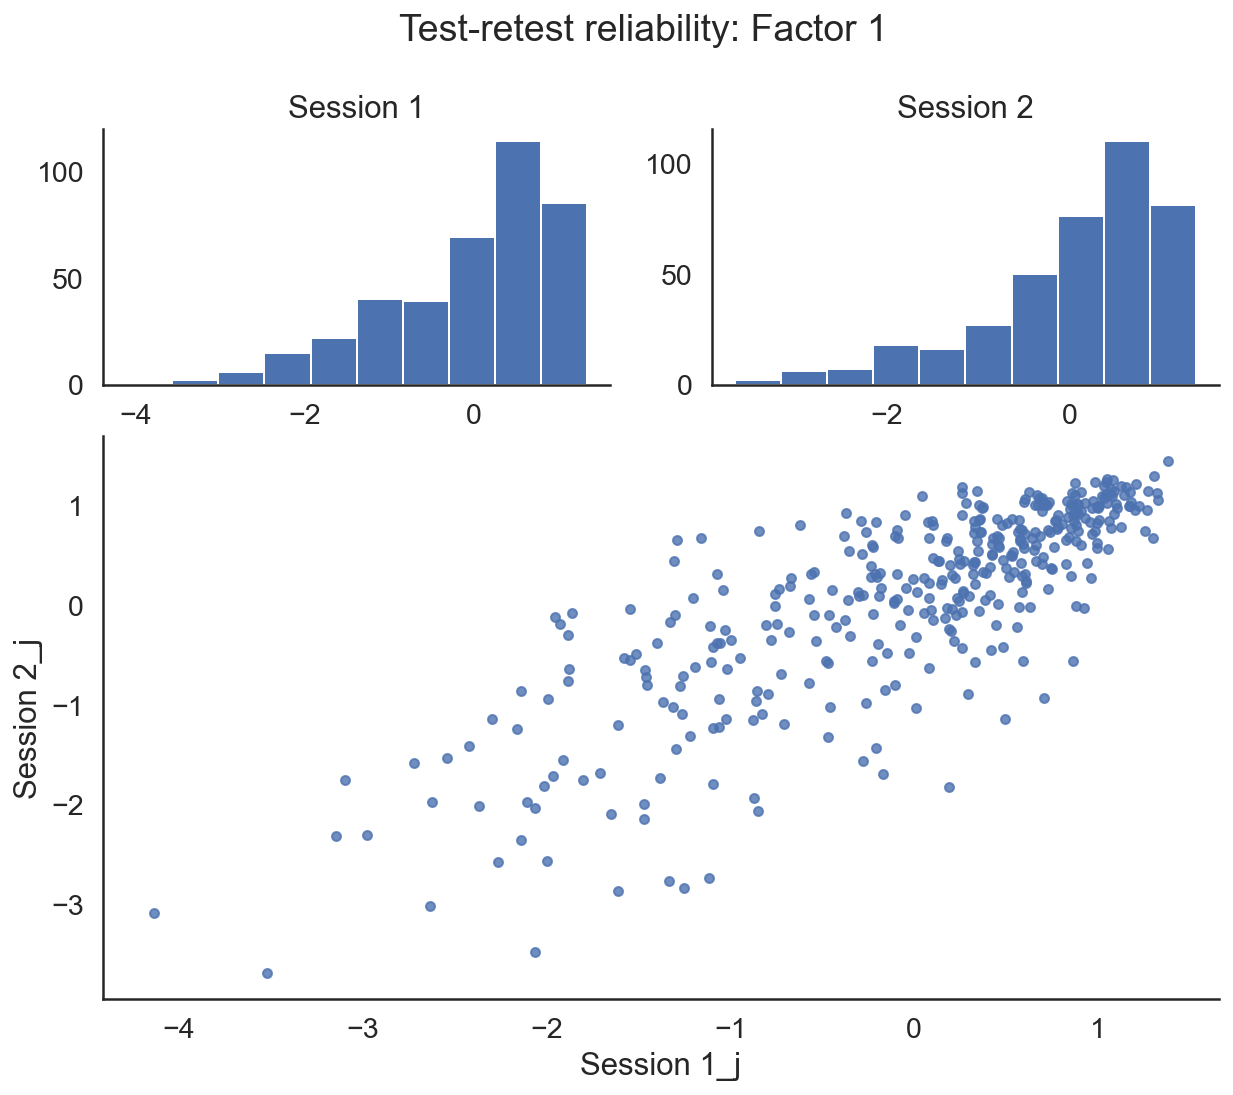

In [ ]:
import trr265.stats as stats

iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'Factor 1', add_jitter = True)

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.794,8.687,392.0,393.0,0.0,0.761,0.822,".79 (.76, .82)"
Single_random_raters,ICC2,0.795,9.493,392.0,392.0,0.0,0.745,0.834,".80 (.74, .83)"
Single_fixed_raters,ICC3,0.809,9.493,392.0,392.0,0.0,0.779,0.836,".81 (.78, .84)"
Average_raters_absolute,ICC1k,0.885,8.687,392.0,393.0,0.0,0.864,0.903,".88 (.86, .90)"
Average_random_raters,ICC2k,0.886,9.493,392.0,392.0,0.0,0.854,0.910,".89 (.85, .91)"
Average_fixed_raters,ICC3k,0.895,9.493,392.0,392.0,0.0,0.876,0.911,".89 (.88, .91)"


,variance,Percent
ID,0.816,0.795
Items,0.018,0.017
Residual,0.192,0.187
Total,1.027,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


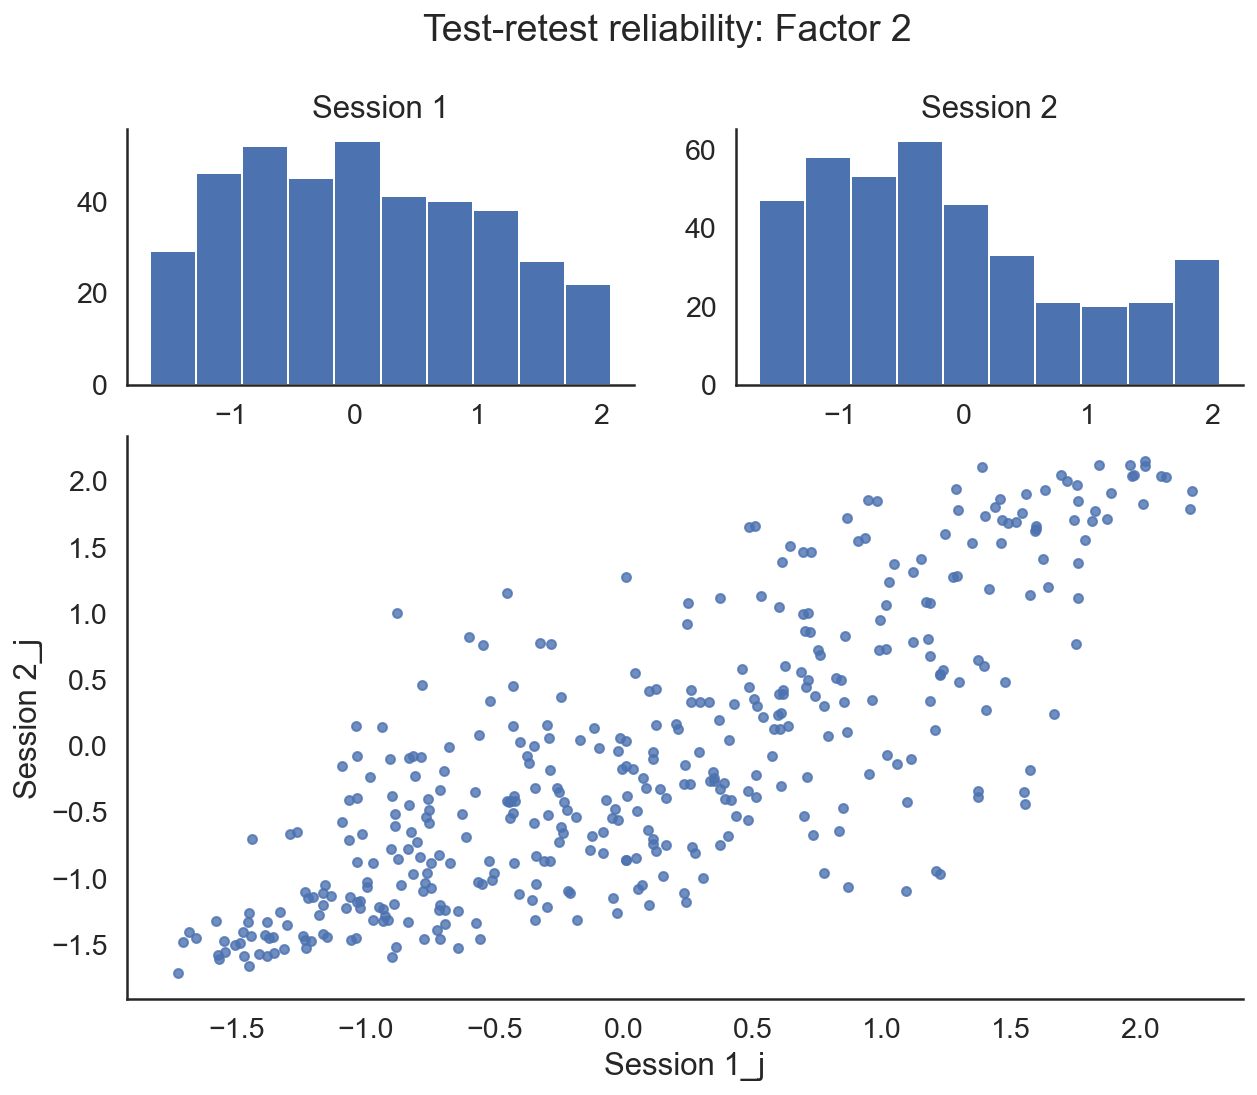

In [ ]:
iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'Factor 2', add_jitter = True)

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.821,10.160,392.0,393.0,0.0,0.792,0.846,".82 (.79, .85)"
Single_random_raters,ICC2,0.821,10.281,392.0,392.0,0.0,0.792,0.846,".82 (.79, .85)"
Single_fixed_raters,ICC3,0.823,10.281,392.0,392.0,0.0,0.794,0.848,".82 (.79, .85)"
Average_raters_absolute,ICC1k,0.902,10.160,392.0,393.0,0.0,0.884,0.917,".90 (.88, .92)"
Average_random_raters,ICC2k,0.902,10.281,392.0,392.0,0.0,0.884,0.917,".90 (.88, .92)"
Average_fixed_raters,ICC3k,0.903,10.281,392.0,392.0,0.0,0.885,0.918,".90 (.89, .92)"


,variance,Percent
ID,0.827,0.821
Items,0.002,0.002
Residual,0.178,0.177
Total,1.007,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


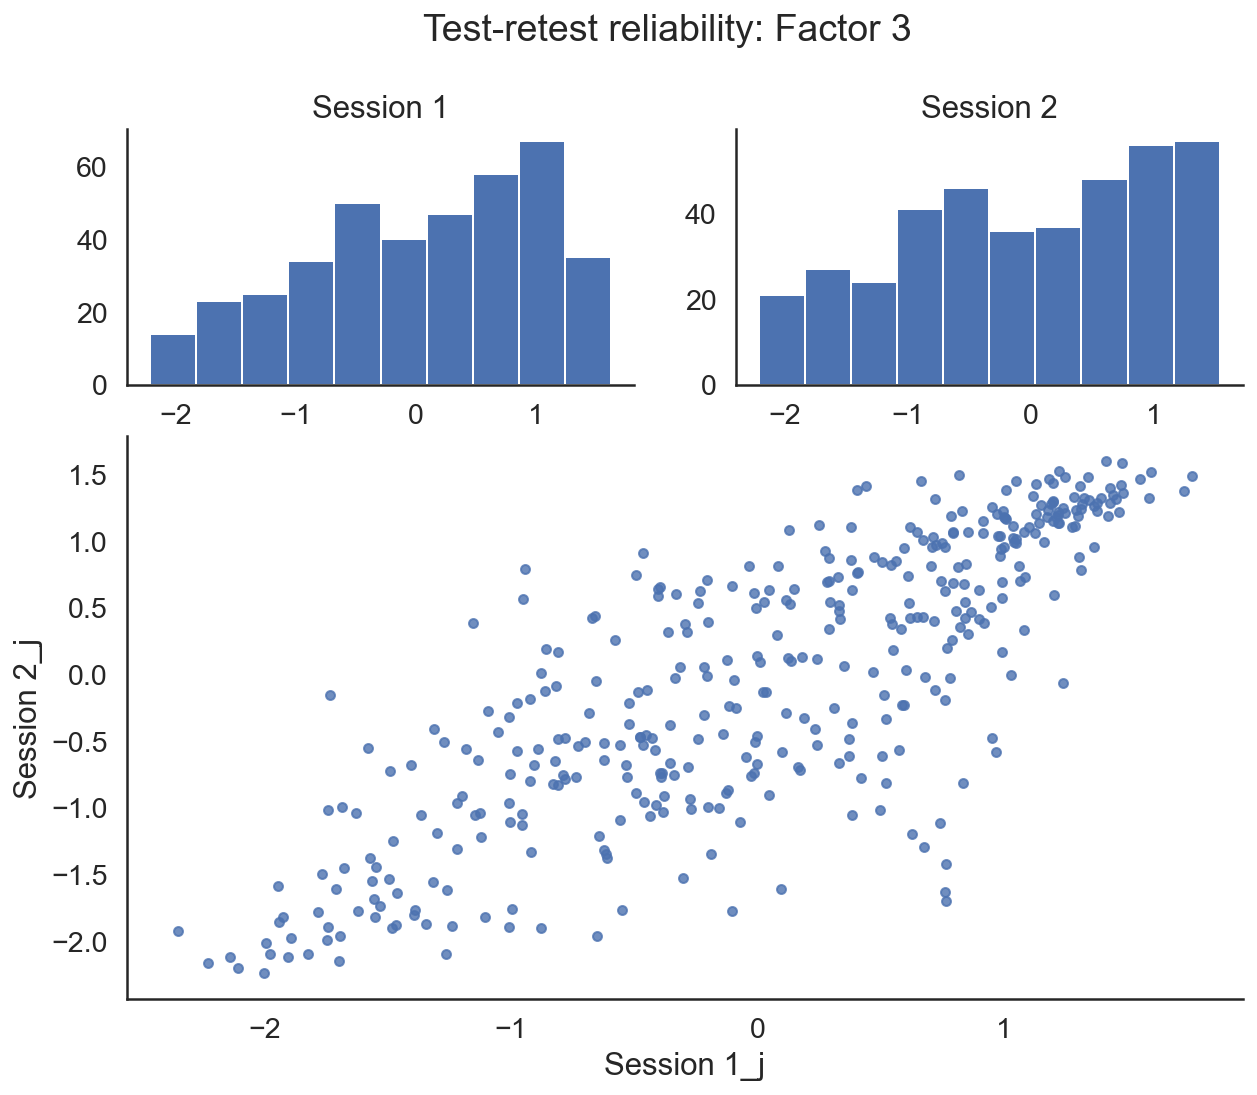

In [ ]:
iccs_mean = stats.analyze_reliability(factor_scores, dependent = 'Factor 3', add_jitter = True)

### Factor score correlation with drinking

In [ ]:
initial_participants = dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']).query("is_initial").participant.unique()
ba = dp.get_ba_data(columns = ['redcap_event_name','mov_id','bx_aud_sum']).query("redcap_event_name=='erhebungszeitpunkt_arm_1'")
ba = ba[ba.mov_id.isin(initial_participants)]
aud = ba[~ba.bx_aud_sum.isnull()][['mov_id','bx_aud_sum']]
aud.columns = ['participant','aud']
aud = aud.groupby('participant').first()
standard_last_three = dp.get_baseline_drinking_data().loc[initial_participants]
two_day = dp.get_two_day_data()
drinking_days = two_day.query("sampling_day<30")#.groupby('participant').g_alc.agg(['mean','median'])
drinking_days['drinking_days'] = drinking_days.g_alc>0
drinking_days = drinking_days.groupby('participant')[['g_alc','drinking_days']].sum().reset_index()
drinking_days = drinking_days[drinking_days.participant.isin(initial_participants)].set_index('participant')
drinking_days['g_alc_per_drinking_day'] = drinking_days.g_alc / drinking_days.drinking_days
drinking_days.replace([np.inf, -np.inf], np.nan).isna().sum()
drinking_days = drinking_days[['drinking_days','g_alc_per_drinking_day']]
two_day = dp.get_two_day_data()
average_ema = two_day.query("sampling_day<30").groupby('participant').g_alc.agg(['mean','median'])
average_ema.columns = ['mean_g_alc','median_g_alc']
average_ema = average_ema.reset_index()
average_ema = average_ema[average_ema.participant.isin(initial_participants)].set_index('participant')
standard_last_three['g_alc_per_drinking_day_last_three_month'] = standard_last_three.drinks_per_drinking_day_last_three_month * 12
standard_last_three['g_alc_per_day_last_three_month'] = standard_last_three.last_three_month * 12
drinking = pd.concat([standard_last_three[['g_alc_per_day_last_three_month','drinking_days_last_three_month','g_alc_per_drinking_day_last_three_month']], aud, average_ema, drinking_days],axis = 1)


In [ ]:
pp_factor_scores = factor_scores.groupby('participant').mean().filter(like='Factor')
pp_factor_scores

,Factor 1,Factor 2,Factor 3
participant,,,
b001,0.589093,-0.424154,0.241612
b002,0.915273,1.039202,1.264265
b012,0.485963,1.412792,0.547481
b013,-3.567315,-0.382270,-0.764629
b015,0.594388,1.430377,-0.064311
...,...,...,...
m297,-2.232306,1.746382,1.155274
m299,1.077790,-0.069052,0.166673
m300,1.102332,0.106614,0.021375


In [ ]:
result = pd.concat([pp_factor_scores, drinking], axis=1, join="inner").dropna()

In [ ]:
import numpy as np
import trr265.stats as stats
import scipy.stats


def correl(df, corr_func = scipy.stats.pearsonr):
    df_corr = pd.DataFrame() # Correlation matrix
    
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = corr_func(df[x], df[y])
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .05, bonferroni = False, size = (11,9), show_correl = True, corr_func = scipy.stats.pearsonr):
    print(len(analysis_data))

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data, corr_func = corr_func)
    sig = (df_p < alpha).replace({True:"*",False:""})
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    df_corr_label = df_corr.applymap(lambda x: '%.2f'%x)
    df_corr_label = df_corr_label + sig
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr_label,fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()

247


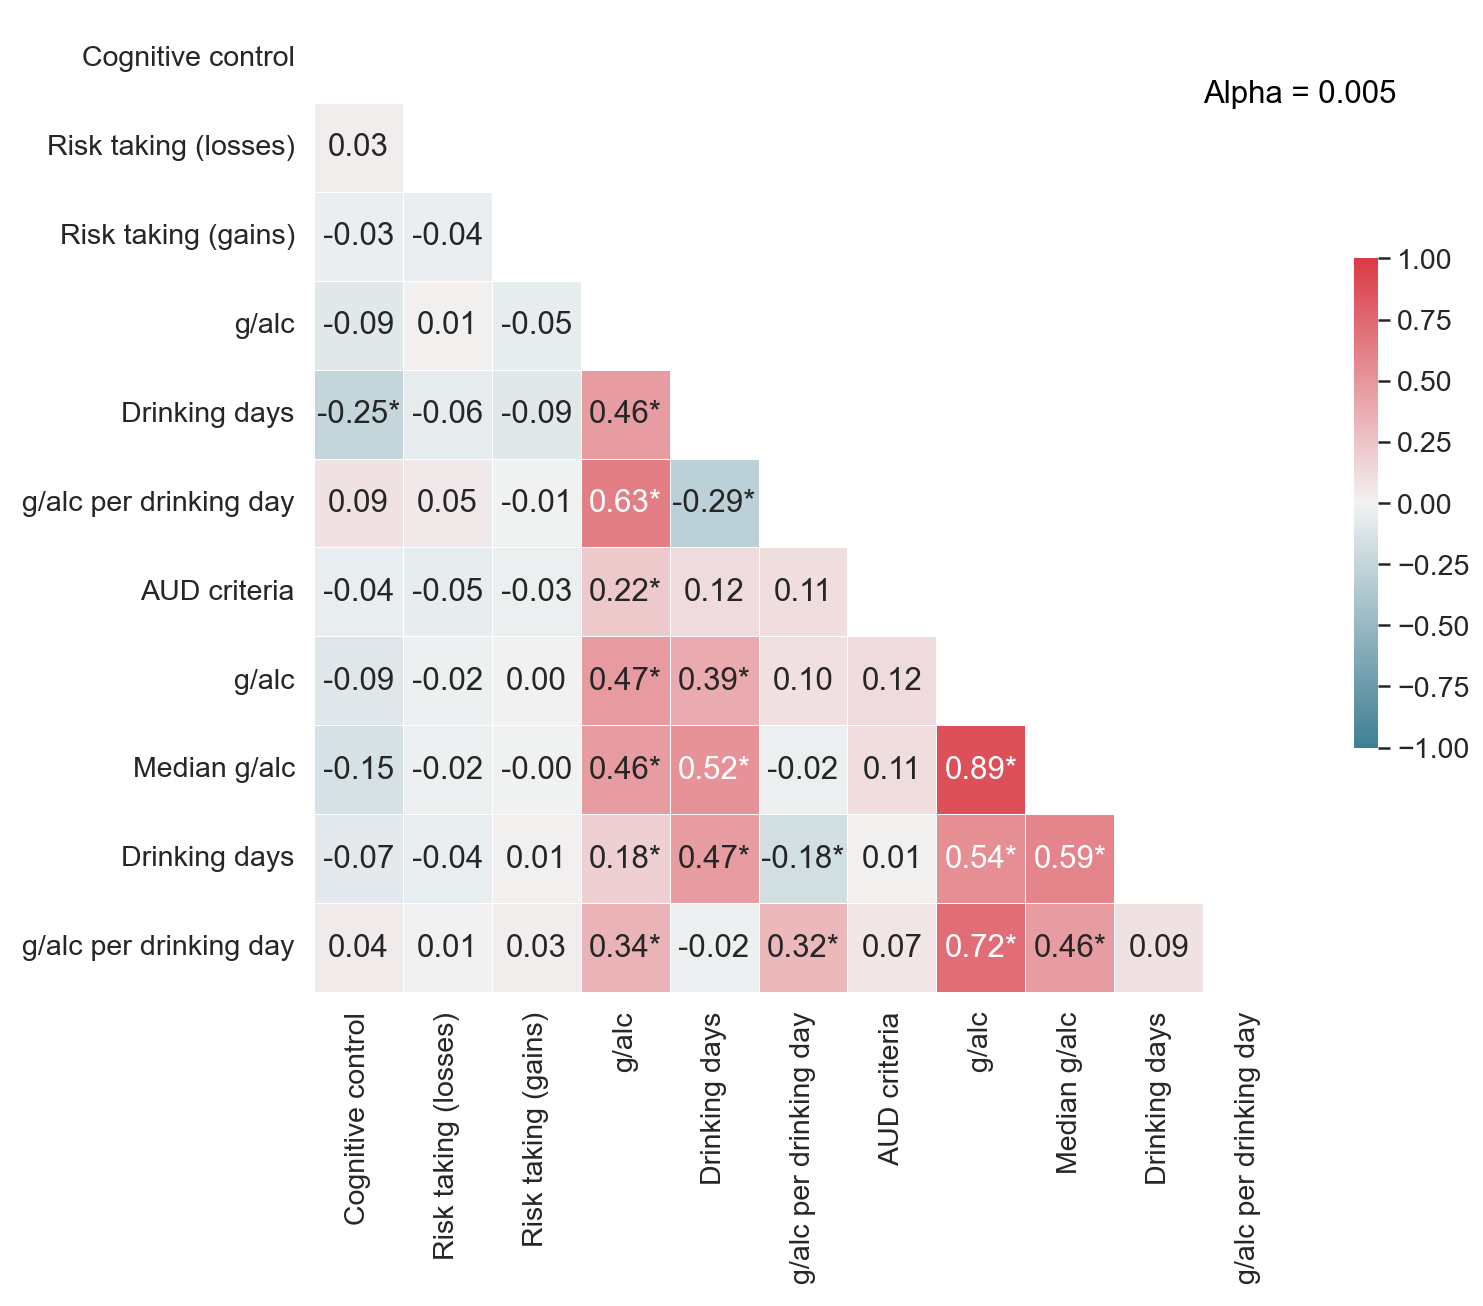

In [ ]:
labels = {
    "wm_no_1":"no distractor (long)",
    "wm_no_2":"no distractor (short)",
    "wm_encoding":"encoding distractor",
    "wm_delayed":"delayed distractor",
    "rtt_win":"% gambles (win)",
    "rtt_loss":"% gambles (loss)",
    "rtt_mixed":"% gambles (mixed)",
    "ist_oversampling":"oversampling",
    "last_three_month":"Drinks per day",
    "g_alc_per_day_last_three_month":"g/alc",
    "g_alc_per_drinking_day_last_three_month":"g/alc per drinking day",
    "drinking_days_last_three_month":"Drinking days",
    "drinks_per_drinking_day_last_three_month":"Drinks per drinking day",
    "aud":"AUD criteria",
    "mean_g_alc":" g/alc",
    "median_g_alc":"Median g/alc",
    "drinking_days":" Drinking days",
    "g_alc_per_drinking_day":" g/alc per drinking day",
    "Factor 1": "Cognitive control",
    "Factor 2": "Risk taking (losses)",
    "Factor 3": "Risk taking (gains)"
}
result = result.rename(columns = labels) 
correlation_matrix(result, alpha = .005)

### Cognitive control correlations

In [ ]:
stats.pearsonr(result['Cognitive control'], result['Drinking days'])

(-0.24892894430606916, 7.659457877982701e-05)

<AxesSubplot:xlabel='Cognitive control', ylabel='Drinking days'>

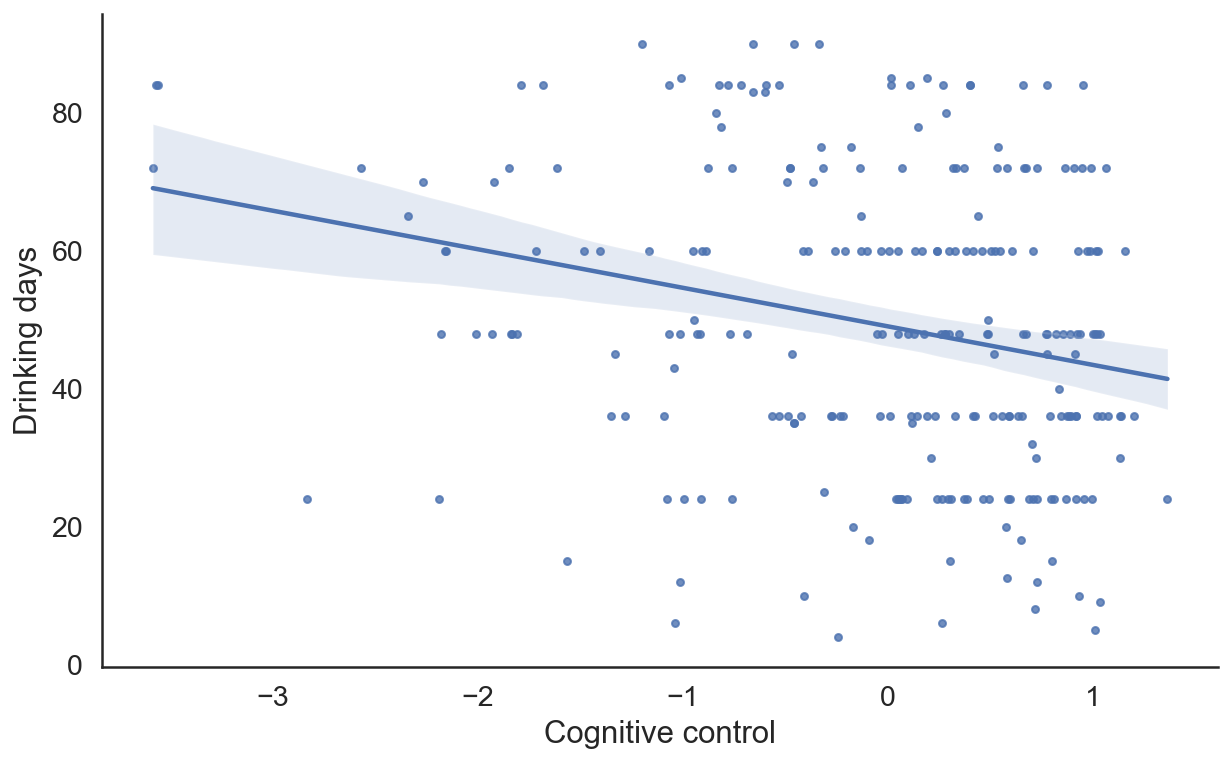

In [ ]:
plt.figure(figsize=(10,6))

sns.regplot(x = 'Cognitive control', y = 'Drinking days', data=result, scatter_kws={'s':12})

In [ ]:
stats.pearsonr(result['Cognitive control'], result['Median g/alc'])

(-0.14565167537282128, 0.022038246133662627)

<AxesSubplot:xlabel='Cognitive control', ylabel='Median g/alc'>

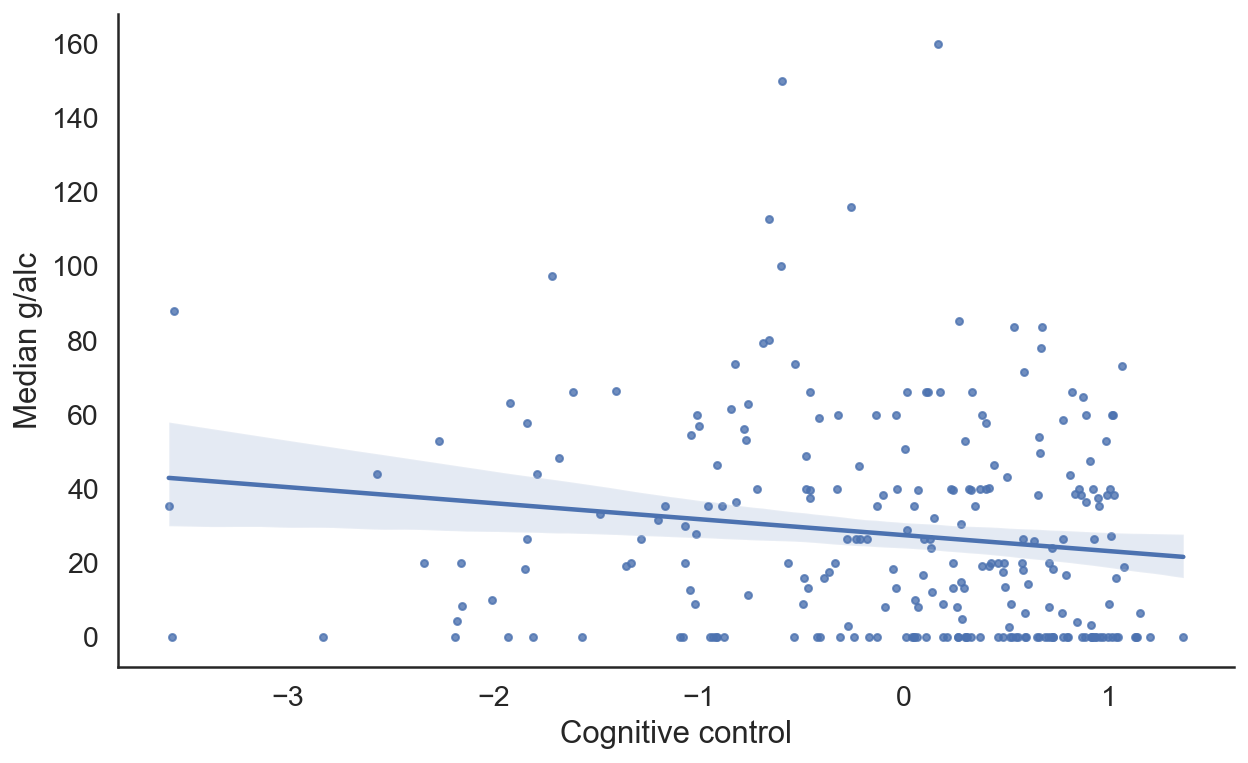

In [ ]:
plt.figure(figsize=(10,6))

sns.regplot(x = 'Cognitive control', y = 'Median g/alc', data=result, scatter_kws={'s':12})

247


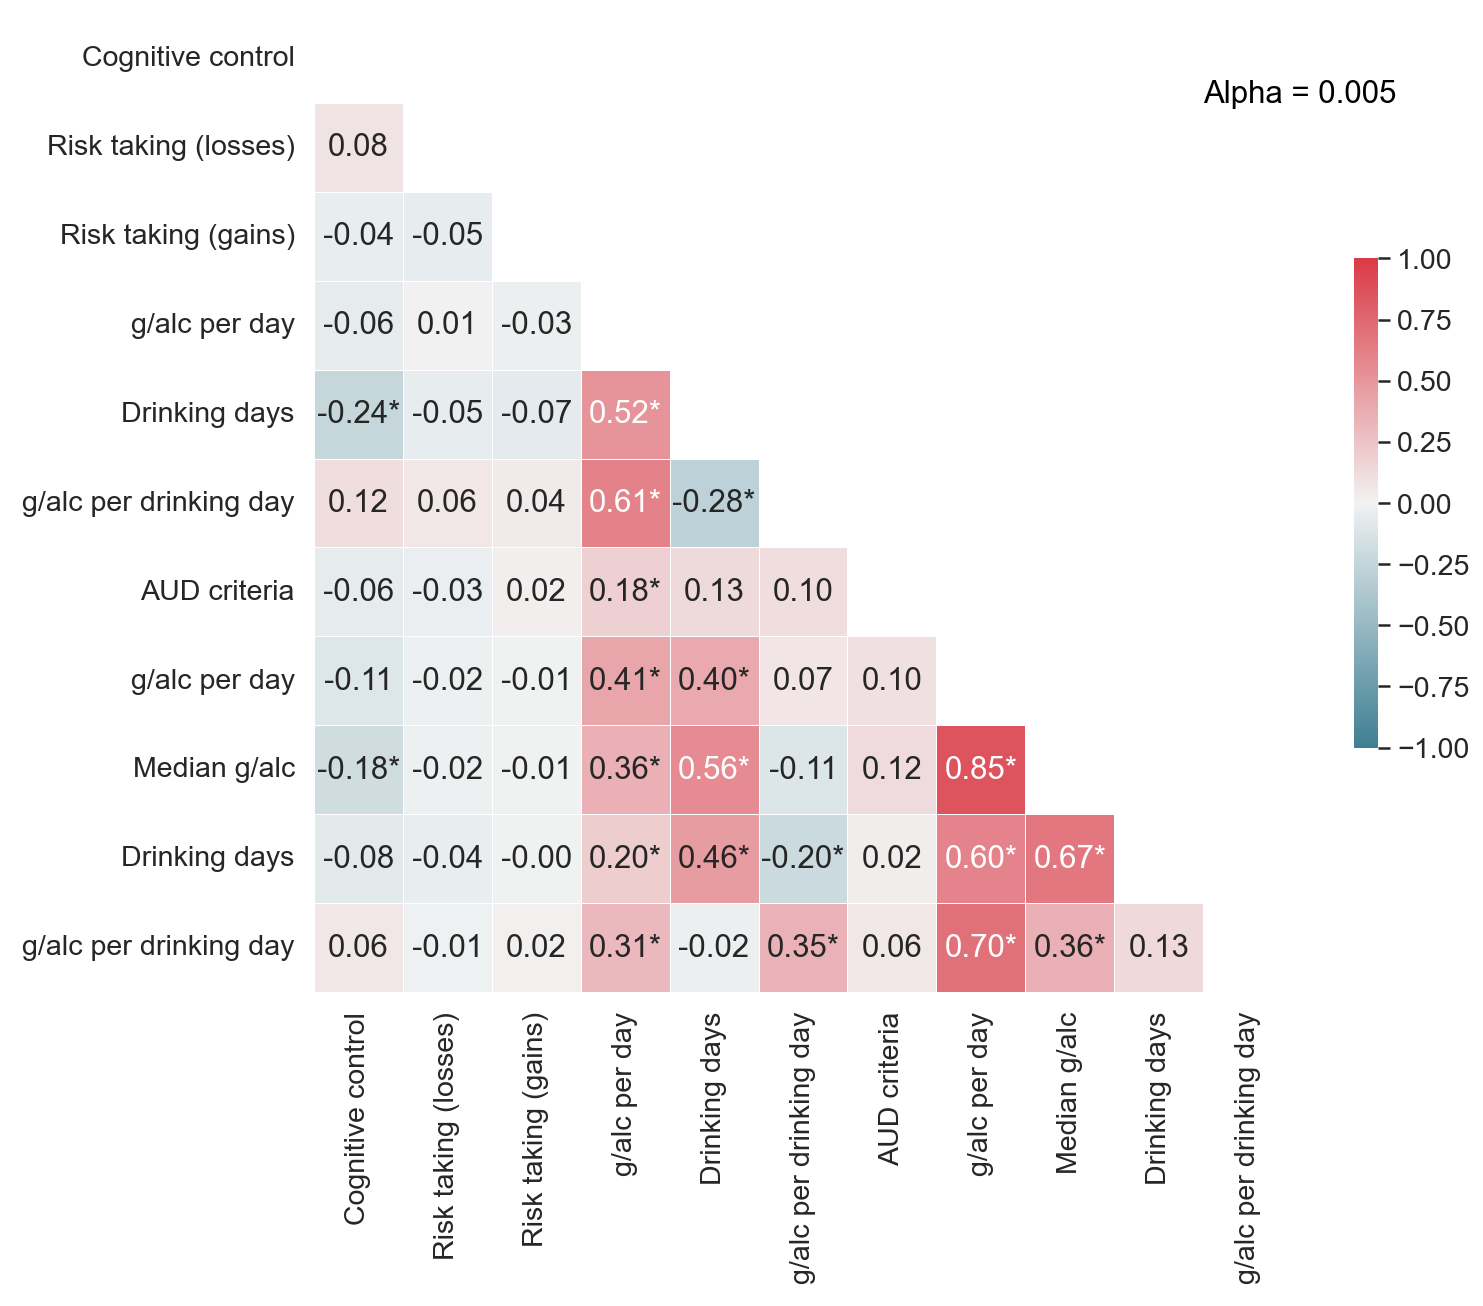

In [ ]:
correlation_matrix(result, corr_func = scipy.stats.spearmanr, alpha = .005)

247


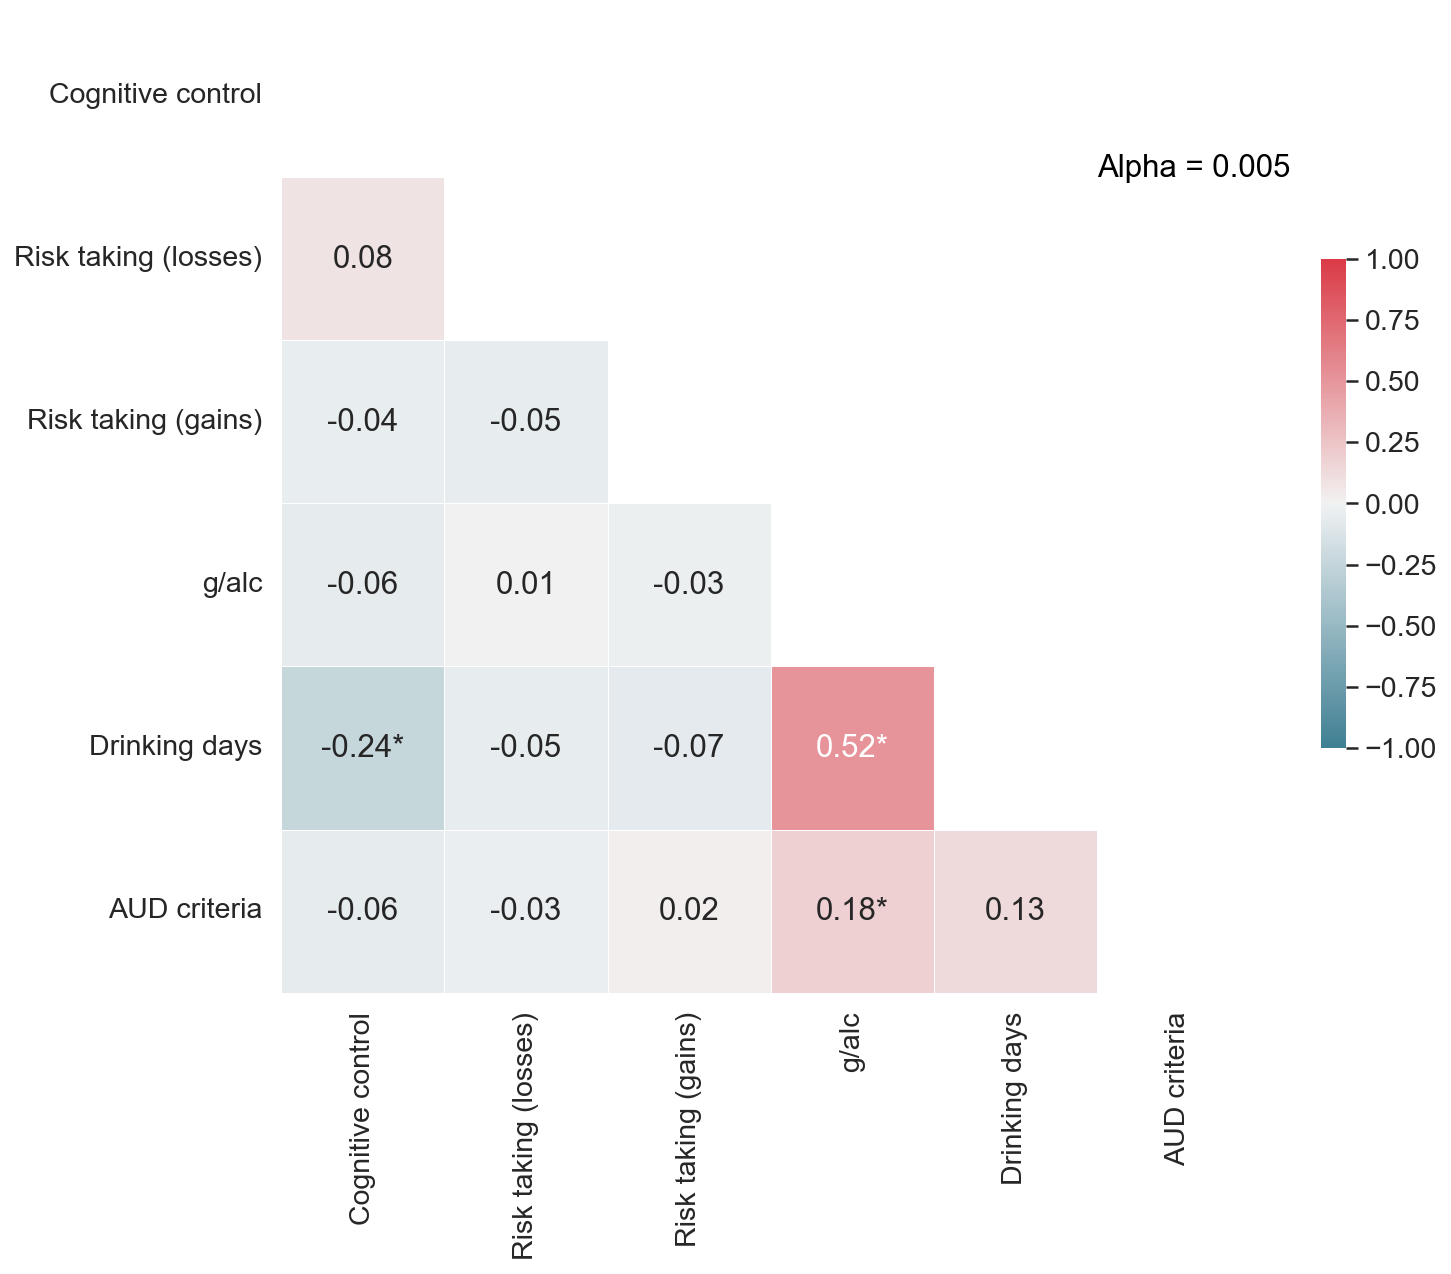

In [ ]:
correlation_matrix(result[result.columns[:-4]].drop(columns=["g/alc per drinking day"]), corr_func = scipy.stats.spearmanr, alpha = .005)

In [ ]:
from scipy.stats import spearmanr

In [ ]:
spearmanr(result['Cognitive control'], result['Drinking days'])

SpearmanrResult(correlation=-0.24026599619075667, pvalue=0.0001373315742388409)

In [ ]:
spearmanr(result['Cognitive control'], result['Median g/alc'])

SpearmanrResult(correlation=-0.1804330630327967, pvalue=0.004444924778716368)

## Model based RTT scores

In [ ]:
rtt_columns = 'PT_alphaL, PT_alphaG, PT_lambda, PT_mu, AA_alphaL, AA_alphaG, AA_lambda, AA_pavL, AA_pavG, AA_mu'.split(', ')

In [ ]:
rtt_data_md = pd.read_pickle('../data/interim/rtt_data_md.pkl').query('sess<3').groupby('mov_id').mean()[rtt_columns]

In [ ]:
#rtt_data_md.query('sess<3').groupby()
rtt_data_md

,PT_alphaL,PT_alphaG,PT_lambda,PT_mu,AA_alphaL,AA_alphaG,AA_lambda,AA_pavL,AA_pavG,AA_mu
mov_id,,,,,,,,,,
b001,1.084158,1.109519,1.604457,0.072628,0.618273,0.778262,3.884493,-0.603851,6.378510e-01,11.517757
b002,1.040298,1.300000,1.821965,0.115797,0.676463,0.880464,1.538709,-0.549437,8.999609e-01,15.201869
b012,0.568422,1.106224,4.119697,0.195486,0.636303,0.979183,2.192513,-0.055530,5.438565e-01,14.684398
b013,0.558536,0.618440,0.500000,0.329873,0.608623,0.890292,2.840893,-0.358014,-2.064915e-01,0.438815
b015,0.381695,0.965828,4.727913,0.229861,0.508332,0.987235,2.938781,0.140498,-3.524636e-02,5.234509
...,...,...,...,...,...,...,...,...,...,...
m275,1.150979,0.932930,0.500000,0.163072,0.722951,0.817723,2.749171,-0.812250,-7.845474e-02,10.210561
m276,1.088776,0.716872,0.820660,0.680804,1.022775,1.055683,3.174101,-0.249970,-6.346600e-01,12.518339
m279,1.299276,1.108214,0.943518,0.083546,0.963585,0.933411,2.749996,-0.898657,2.537230e-01,0.176385


In [ ]:
merged = tasks.drop(columns = ['rtt_win','rtt_loss','rtt_mixed']).merge(rtt_data_md, left_index = True, right_index = True, validate = 'one_to_one')

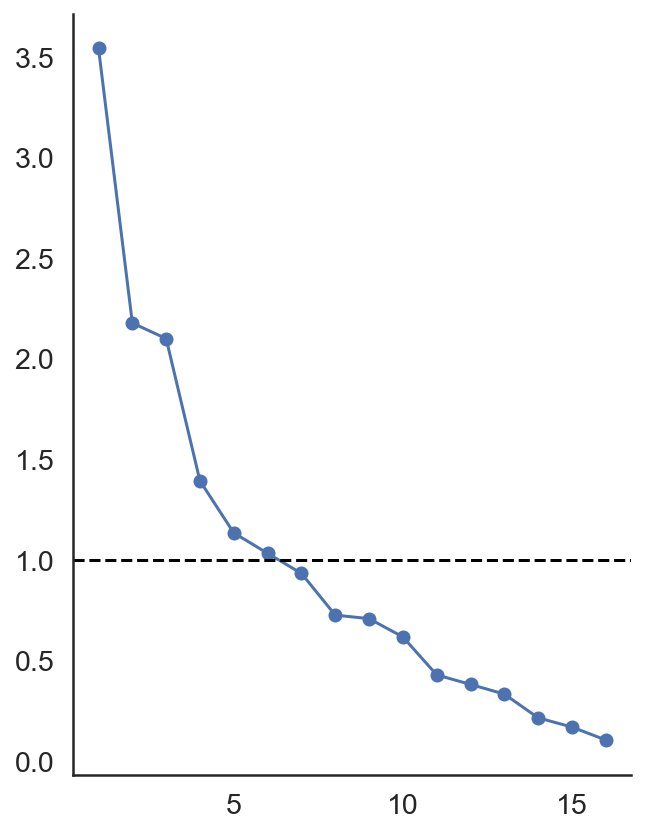

0.6826568812022605


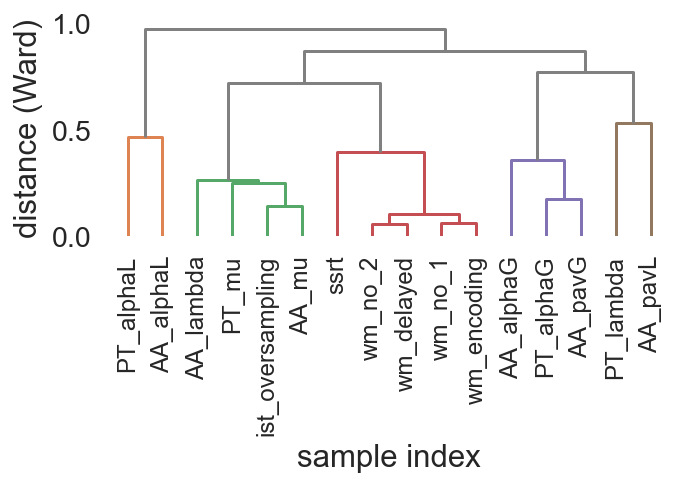

<AxesSubplot:>

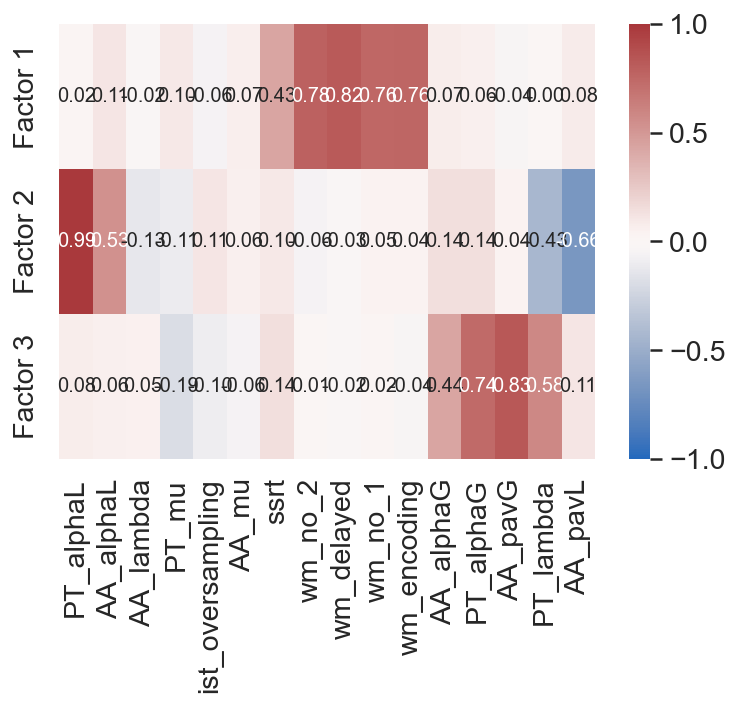

In [ ]:
check_factor_analysis(merged)
scree_plot(merged, rotation = 'oblimin')
fa = factor_analysis(merged, 3, rotation = 'oblimin')
factor_loadings = get_factor_loadings(fa, merged)
dendo = dendogram(factor_loadings)
factor_loading_heatmap(factor_loadings, dendo['ivl'])